
# **Financial Data Analysis using Machine and Deep Learning**

### Assignment #3

20180594 이정훈

Let assume that you're a fund manager who manages the fund receiving the money. One day, a customer comes in and leaves the money and asks you to organize a portfolio that meets the following conditions, based on which, answer the following questions.

**Using following assumptions**

- Prepare a portfolio using following stocks : Samsung Electronics, NC soft, SK hynix, Kakao, Naver
- Using Daily datas during 2019.1.1 ~ 2020.1.1
- Calculate the expected return rate using ${P_t - P_{t-1}}\over{P_{t-1}}$, where $t$ means daily frequency.
- Consider 60% risky asset to Samsung Electronics, not considering risk-free assets.
- The weights of all assets in the portfolio is between 0 and 100%.
- Prepare the portfolio with the highest expected return on risky units.

1. Fix Samsung Electronics' weight at 60%, and generate 5,000 random portfolios randomly assigned the remaining weights to derive a mean-variance frontier consisting of only risky assets.

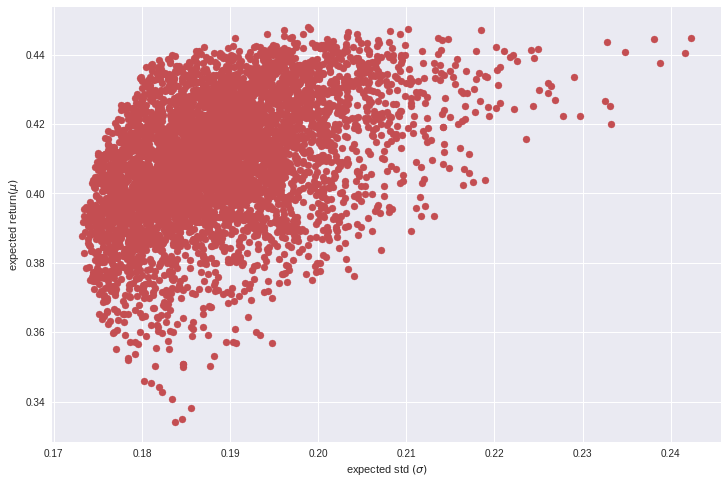

In [129]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()
import pandas_datareader.data as web
%matplotlib inline

data = pd.DataFrame()
#where stock number of Samsung is 005930, NC soft = 036570, SK Hynix = 000660, Kakao = 035720, Naver = 035420
for code in ['005930', '036570', '000660', '035720', '035420'] : 
    data = pd.concat([data,web.DataReader(code, 'naver', start='2019-01-01', end='2020-01-01')['Close'].apply(int)], axis=1)

data.columns = ['Samsung', 'NC Soft', 'SK Hynix', 'Kakao', 'Naver']
noa = len(data.columns)

ret = data.pct_change().dropna()

port_rets = []
port_std = []

def ret_std(weight, ret):
    port_mean = np.sum(weight * ret.mean() * 252)
    port_var = np.dot(weight.T, np.dot(ret.cov()*252, weight))
    port_std = np.sqrt(port_var)
    return port_mean, port_std

for w in range(5000):
    weight_samsung = np.array([0.6])
    weight = np.random.random(noa-1)
    weight /= np.sum(weight)
    weight *= 0.4
    weight = np.r_[weight_samsung,weight]
    mu, sig = ret_std(weight, ret)
    port_rets.append(mu)
    port_std.append(sig)
  
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.scatter(port_std, port_rets, marker='o', color = 'r')
plt.ylabel('expected return$(μ)$')
plt.xlabel('expected std $(σ)$');
plt.grid(True)

**Get Sharpe Ratio**

set rf=0 up because only we selected risky assets

In [130]:
import scipy.optimize as opt

def statistics(weights, rf=0):
    weights = np.array(weights) 
    pret = np.sum(ret.mean() * weights) * 252 - rf
    pvol = np.sqrt(np.dot(weights.T, np.dot((ret).cov() * 252 , weights)))
    return np.array([pret, pvol, pret / pvol])

def min_func_sharpe(weights, rf=0):
    return -statistics(weights, rf)[2]

def min_func_volatility(weights):
    return statistics(weights)[1] ** 2 

opts = opt.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                    bounds=tuple((0, 1) for x in range(noa)),
                    constraints=({'type': 'eq', 'fun': lambda x:  np.sum(x)-1}))

optv = opt.minimize(min_func_volatility, noa * [1. / noa,], method='SLSQP',
                    bounds = tuple((0, 1) for x in range(noa)),
                    constraints = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1}))

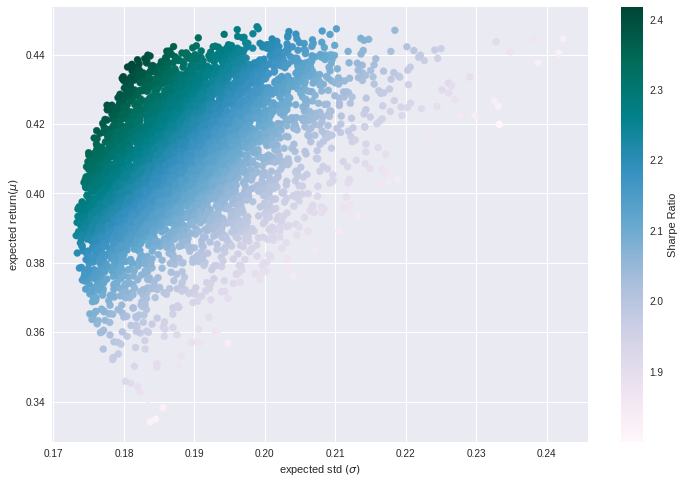

In [131]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.scatter(port_std, port_rets,c = np.array(port_rets)/np.array(port_std), marker='o',  cmap='PuBuGn')
plt.colorbar(label='Sharpe Ratio')
plt.ylabel('expected return$(μ)$')
plt.xlabel('expected std $(σ)$');
plt.grid(True)

In [132]:
def min_func_port(weights):
    return statistics(weights)[1]

trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = opt.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=tuple((0, 1) for x in weight),
                       constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

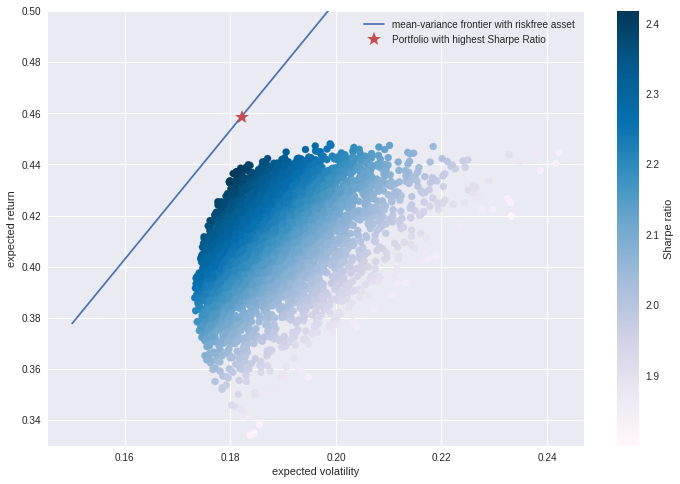

In [133]:
rf = 0
slope = (statistics(opts['x'])[0] - rf) / statistics(opts['x'])[1]
var_list = [x*slope + rf for x in np.linspace(0.15,0.24,5000)]

x =  np.linspace(0.15,0.24,5000)
y = var_list

plt.figure(figsize=(12, 8))
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker='o',  cmap='PuBu')
plt.plot(x,y, label = 'mean-variance frontier with riskfree asset')  
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')
plt.ylim((0.33, 0.5))
plt.legend()
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')   

2. When the risk-free rate is 0.02, derive the mean-variance frontier including risk-free assets and obtain the analyzed sharpe-ratio of the optimal portfolio (calculated as 252 days in one year).

In [116]:
#Get sharpe ratio

import scipy.optimize as opt

def statistics(weights, rf=0.02):
    weights = np.array(weights) 
    pret = np.sum(ret.mean() * weights) * 252 - rf
    pvol = np.sqrt(np.dot(weights.T, np.dot((ret).cov() * 252 , weights)))
    return np.array([pret, pvol, pret / pvol])

def min_func_sharpe(weights, rf=0.02):
    return -statistics(weights, rf)[2]

def min_func_volatility(weights, rf=0.02):
    return statistics(weights, rf)[1] ** 2 

opts = opt.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                    bounds=tuple((0, 1) for x in range(noa)),
                    constraints=({'type': 'eq', 'fun': lambda x:  np.sum(x)-1}))

optv = opt.minimize(min_func_volatility, noa * [1. / noa,], method='SLSQP',
                    bounds = tuple((0, 1) for x in range(noa)),
                    constraints = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1}))

### **Optimized Mean-Variance Portfolio Frontier**

**port_std** means expected degree of portfolio risk, and **port_rets** means expected return of Portfolio.

I'm using Sharpe Ratio to calculate **np.array(port_rets)/np.array(port_std)**

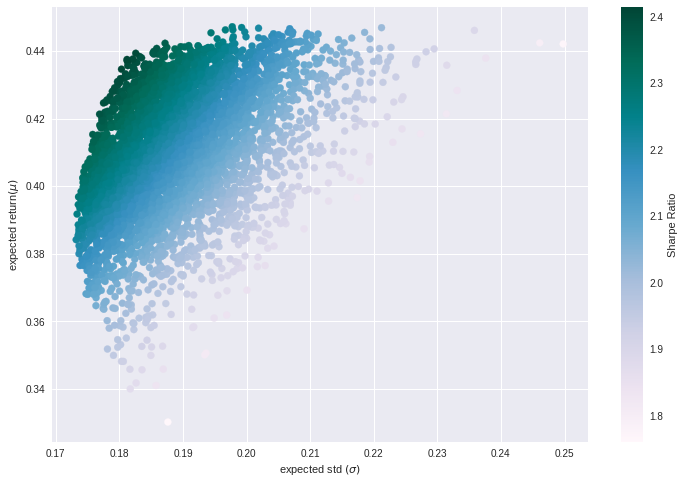

In [117]:
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.scatter(port_std, port_rets,c = np.array(port_rets)/np.array(port_std), marker='o',  cmap='PuBuGn')
plt.colorbar(label='Sharpe Ratio')
plt.ylabel('expected return$(μ)$')
plt.xlabel('expected std $(σ)$');
plt.grid(True)

###**Annualized sharpe-ratio of Efficient Portfolio**

In [118]:
def min_func_port(weights):
    return statistics(weights)[1]

trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = opt.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=tuple((0, 1) for x in weight),
                       constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

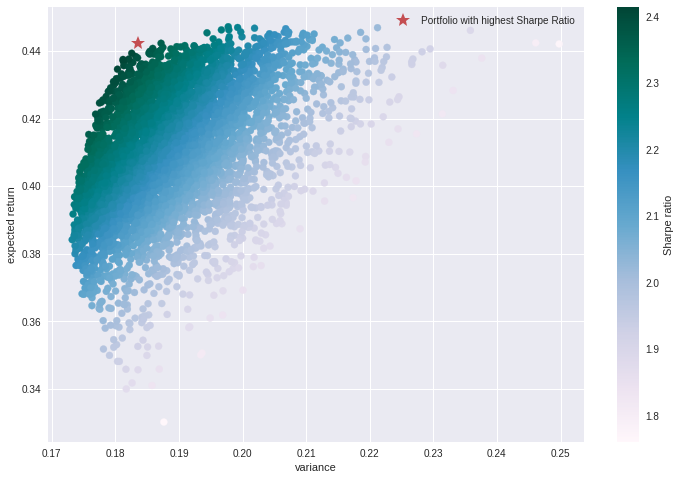

In [120]:
plt.figure(figsize=(12, 8))
plt.scatter(port_std, port_rets,c = np.array(port_rets)/np.array(port_std), marker='o',  cmap='PuBuGn')
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.xlabel('variance')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

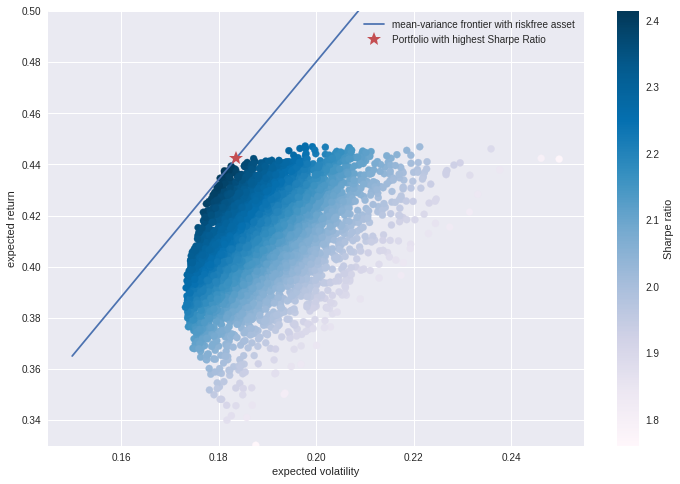

In [121]:
rf = 0.02
slope = (statistics(opts['x'])[0] - rf) / statistics(opts['x'])[1]
var_list = [x*slope + rf for x in np.linspace(0.15,0.24,5000)]

x =  np.linspace(0.15,0.24,5000)
y = var_list

plt.figure(figsize=(12, 8))
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker='o',  cmap='PuBu')
plt.plot(x,y, label = 'mean-variance frontier with riskfree asset')  
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')
plt.ylim((0.33, 0.5))
plt.legend()
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')    

Annualized Sharpe Ratio

In [122]:
sr = np.array(port_rets)/np.array(port_std)
sr.sum()/len(sr)

2.1654513202181285

3. Proceed with the above analysis again, except for the condition that 60% of risky assets are made up of Samsung Electronics stocks, and compare the newly obtained optimized portfolio with that of (3-2). What portfolio would you recommend to your customers as a fund manager?

Reset weights of portfolio

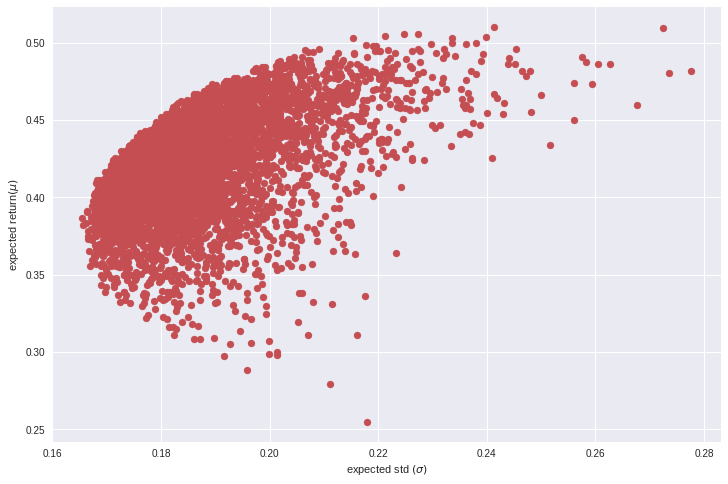

In [123]:
data = pd.DataFrame()
#where stock number of Samsung is 005930, NC soft = 036570, SK Hynix = 000660, Kakao = 035720, Naver = 035420
for code in ['005930', '036570', '000660', '035720', '035420'] : 
    data = pd.concat([data,web.DataReader(code, 'naver', start='2019-01-01', end='2020-01-01')['Close'].apply(int)], axis=1)

data.columns = ['Samsung', 'NC Soft', 'SK Hynix', 'Kakao', 'Naver']
noa = len(data.columns)

ret = data.pct_change().dropna()

port_rets = []
port_std = []

def ret_std(weight, ret):
    port_mean = np.sum(weight * ret.mean() *252)
    port_var = np.dot(weight.T, np.dot(ret.cov()*252, weight))
    port_std = np.sqrt(port_var)
    return port_mean, port_std

for w in range(5000):
    weight = np.random.random(noa)
    weight /= np.sum(weight)
    mu, sig = ret_std(weight, ret)
    port_rets.append(mu)
    port_std.append(sig)
  
plt.style.use('seaborn')
plt.figure(figsize=(12,8))
plt.scatter(port_std, port_rets, marker='o', color = 'r')
plt.ylabel('expected return$(μ)$')
plt.xlabel('expected std $(σ)$');
plt.grid(True)

In [124]:
def statistics(weights, rf=0.02):
    weights = np.array(weights)
    pret = np.sum(ret.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(ret.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

def min_func_sharpe(weights, rf=0.02):
    return -statistics(weights, rf)[2]

def min_func_volatility(weights, rf=0.02):
    return statistics(weights, rf)[1] **2

opts = opt.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP',
                    bounds=tuple((0, 1) for x in range(noa)),
                    constraints=({'type': 'eq', 'fun': lambda x:  np.sum(x)-1}))

optv = opt.minimize(min_func_volatility, noa * [1. / noa,], method='SLSQP',
                    bounds = tuple((0, 1) for x in range(noa)),
                    constraints = ({'type': 'eq', 'fun': lambda x:  np.sum(x)-1}))

In [125]:
def min_func_port(weights):
    return statistics(weights)[1]

trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = opt.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',
                       bounds=tuple((0, 1) for x in weight),
                       constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

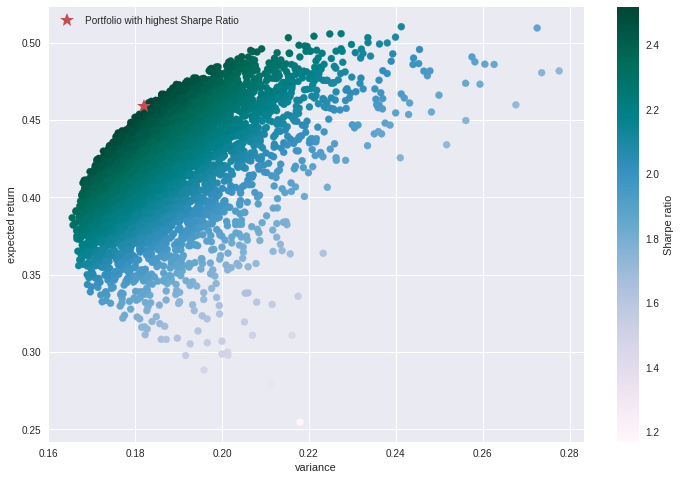

In [126]:
plt.figure(figsize=(12, 8))
plt.scatter(port_std, port_rets,c = np.array(port_rets)/np.array(port_std), marker='o',  cmap='PuBuGn')
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.xlabel('variance')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

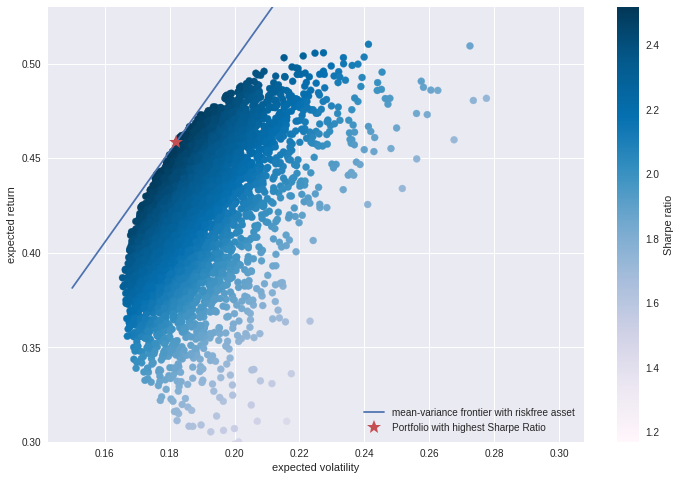

In [127]:
rf = 0.02
slope = (statistics(opts['x'])[0] - rf) / statistics(opts['x'])[1]
var_list = [x*slope + rf for x in np.linspace(0.15,0.3,5000)]

x =  np.linspace(0.15,0.3,5000)
y = var_list

plt.figure(figsize=(12, 8))
plt.scatter(port_std, port_rets,
            c=np.array(port_rets) / np.array(port_std), marker='o',  cmap='PuBu')
plt.plot(x,y, label = 'mean-variance frontier with riskfree asset')  
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],
         'r*', markersize=15.0, label = 'Portfolio with highest Sharpe Ratio')
plt.ylim((0.30, 0.53))
plt.legend()
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')    

Annualized Sharpe Ratio

In [128]:
sr = np.array(port_rets)/np.array(port_std)
sr.sum()/len(sr)

2.232500807076077

I reccomend a portfolio which is (3-3), since the annualized sharpe ratio is higher than (3-2), when optimized efficiently. 

I think that **fund manager** have to recommend the portfolio with the higher expected return on same risky units.